In [493]:
from __future__ import print_function

import math
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.python.data import Dataset

from IPython import display

from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.utils import shuffle

tf.logging.set_verbosity(tf.logging.ERROR)

In [513]:
house_price_df = pd.read_csv('../datasets/housing-prices-dataset/train.csv')
house_price_df = shuffle(house_price_df)

In [495]:
print(house_price_df.head())

        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
290    291          60       RL        120.0    15611   Pave   NaN      Reg   
764    765         120       RL         30.0     9549   Pave   NaN      IR1   
681    682          50       RH         55.0     4500   Pave  Pave      IR2   
1024  1025          20       RL          NaN    15498   Pave   NaN      IR1   
858    859          20       RL         80.0    10400   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
290          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
764          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
681          Bnk    AllPub  ...        0    NaN    NaN         NaN       0   
1024         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
858          Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  

In [496]:
print(house_price_df.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [497]:
housing_features_df = house_price_df[['GrLivArea']]
housing_targets_df = house_price_df[['SalePrice']]

In [498]:
# split data into training, validation, and testing
training_examples = housing_features_df[0:1000]
training_targets = housing_features_df[0:1000]

validation_examples = housing_features_df[1001:1100]
validation_targets = housing_features_df[1001:1100]

testing_examples = housing_features_df[1101:1460]
testing_targets = housing_features_df[1101:1460]

In [499]:
housing_features_df.shape

(1460, 1)

In [500]:
# numeric feature column
my_feature_columns = [tf.feature_column.numeric_column('GrLivArea')]

# define learning rate
learning_rate = 0.1

# define an optimizer
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 0.5)

model = tf.estimator.LinearRegressor(feature_columns=my_feature_columns, 
                                     optimizer=my_optimizer)

In [501]:
def my_input_fn(features, target, batch_size=1, shuffle=True, num_epochs=None):
    
    # convert pandas dataframe into dictionary of np arrays
    features = {key:np.array(value) for key, value in dict(features).items()}
    
    # construct a dataset
    ds = Dataset.from_tensor_slices((features,target))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # shuffle the data
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
        
    # return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    
    return features, labels

In [502]:
_ = model.train(input_fn=lambda:my_input_fn(training_exampels,training_targets), steps=1000)

In [503]:
# evaluating model with RMSE
train_predictions = model.predict(input_fn=lambda: my_input_fn(training_exampels,
                                                                 training_targets, 
                                                                 num_epochs=1, 
                                                                 shuffle=False))
                                                                 
val_predictions = model.predict(input_fn=lambda: my_input_fn(validation_examples,
                                                                 validation_targets,
                                                                 num_epochs=1,
                                                                 shuffle=False))

test_predictions = model.predict(input_fn=lambda: my_input_fn(testing_examples,
                                                                 testing_targets,
                                                                 num_epochs=1,
                                                                 shuffle=False))
                                                                 

In [504]:
# format the predictions as numpy array, then we can calculate the error metrics
train_predictions = np.array([item['predictions'][0] for item in train_predictions])
val_predictions = np.array([item['predictions'][0] for item in val_predictions])
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

In [505]:
mean_squared_error = metrics.mean_squared_error(train_predictions, training_targets)
root_mean_squared_error = math.sqrt(mean_squared_error)

mean_squared_error = metrics.mean_squared_error(val_predictions, validation_targets)
root_mean_squared_error = math.sqrt(mean_squared_error)

mean_squared_error = metrics.mean_squared_error(test_predictions, testing_targets)
root_mean_squared_error = math.sqrt(mean_squared_error)

In [506]:
print('root mean squared error (RMSE) on VALIDATION data: {:0.3}'.format(root_mean_squared_error))
print("root mean squared error (RMSE) on TRAINING data: {:0.3f}".format(root_mean_squared_error))
print('root mean squared error (RMSE) on TESTING data: {:0.3}'.format(root_mean_squared_error))

root mean squared error (RMSE) on VALIDATION data: 1.59e+02
root mean squared error (RMSE) on TRAINING data: 159.408
root mean squared error (RMSE) on TESTING data: 1.59e+02


In [507]:
train_sample = housing_df[0:1000].sample(30)
val_sample = housing_df[1001:1100].sample(10)
test_sample = housing_df[1101:1460].sample(10)

In [508]:
# get the min and max total_rooms values
x0 = train_sample['GrLivArea'].min()
x1 = train_sample['GrLivArea'].max()

In [509]:
# Final weight and width and bias generated during training
weight = model.get_variable_value('linear/linear_model/GrLivArea/weights')[0]
bias = model.get_variable_value('linear/linear_model/bias_weights')[0]

In [510]:
# get the predicted median_house_values for min and max of total_rooms 
y0 = weight * x0 + bias
y1 = weight * x1 + bias

Text(0, 0.5, 'SalePrice')

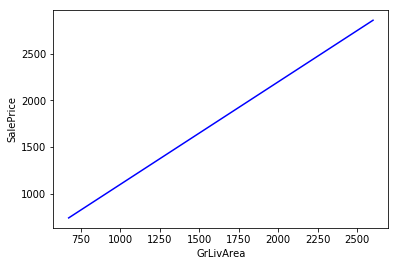

In [511]:
plt.plot([x0,x1],[y0, y1], c='b')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')

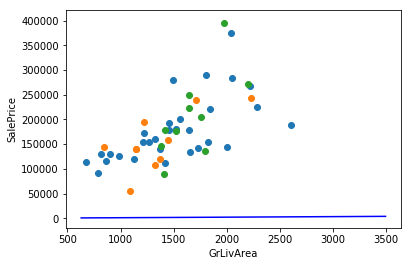

In [512]:
plt.plot([x0,x1],[y0, y1], c='b')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')

plt.scatter(train_sample['GrLivArea'], train_sample['SalePrice'])
plt.scatter(val_sample['GrLivArea'], val_sample['SalePrice'])
plt.scatter(test_sample['GrLivArea'], test_sample['SalePrice'])
plt.show()